In [1]:
import torch

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import sam3
from PIL import Image
from sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results

In [3]:
# Load the model
# Before using SAM 3, please request access to the checkpoints on the SAM 3
# Hugging Face [repo](https://huggingface.co/facebook/sam3). Once accepted, you
# need to be authenticated to download the checkpoints. You can do this by running
# the following [steps](https://huggingface.co/docs/huggingface_hub/en/quick-start#authentication)
# (e.g. `hf auth login` after generating an access token.)
model = build_sam3_image_model()
processor = Sam3Processor(model)

In [4]:
image_path = "./assets/images/boat.jpg"
image = Image.open(image_path)
width, height = image.size
inference_state = processor.set_image(image)

found 11 object(s)


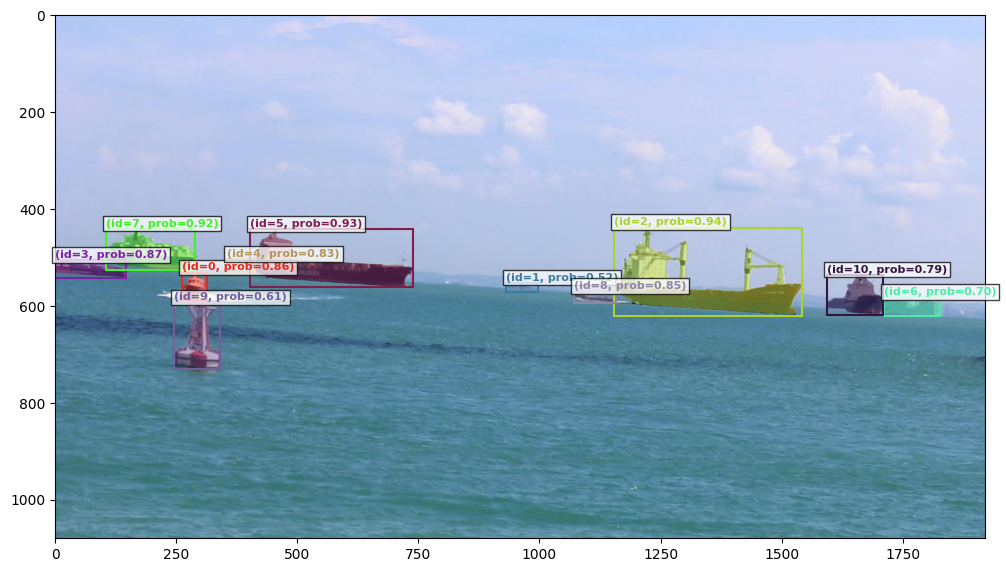

In [ ]:
prompt="boat"
output = processor.set_text_prompt(state=inference_state, prompt=prompt)

img0 = Image.open(image_path)
plot_results(img0, output)

In [6]:
# box_input_xywh = torch.tensor([400.0, 0.0, 110.0, 110.0]).view(-1, 4)
# box_input_cxcywh = box_xywh_to_cxcywh(box_input_xywh)

# norm_box_cxcywh = normalize_bbox(box_input_cxcywh, width, height).flatten().tolist()
# print("Normalized box input:", norm_box_cxcywh)

# processor.reset_all_prompts(inference_state)
# inference_state = processor.add_geometric_prompt(
#     state=inference_state, box=norm_box_cxcywh, label=True
# )

# img0 = Image.open(image_path)
# image_with_box = draw_box_on_image(img0, box_input_xywh.flatten().tolist())
# plt.imshow(image_with_box)
# plt.axis("off")  # Hide the axis
# plt.show()

In [7]:
# plot_results(img0, inference_state)

### Video Inference


In [1]:
import cv2
import os
import torch
import gc
import matplotlib.pyplot as plt
import glob

from sam3.model.sam3_video_predictor import Sam3VideoPredictor
from sam3.model_builder import build_sam3_video_predictor

from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
    save_masklet_video
)

def propagate_in_video(predictor, session_id):
    outputs_per_frame = {}
    responses = predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    )
    for response in responses:
        outputs_per_frame[response["frame_index"]] = response["outputs"]
            
    return outputs_per_frame

def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box": 
        return [[x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT] for x, y, w, h in coords]
    return coords

In [2]:
import subprocess
def ffmpeg_extract_n_frames(input_path, output_path, n_frames):
    # 1. 先獲取影片的 FPS
    cmd_fps = f"ffprobe -v error -select_streams v:0 -show_entries stream=r_frame_rate -of default=noprint_wrappers=1:nokey=1 {input_path}"
    fps_str = subprocess.check_output(cmd_fps, shell=True).decode().strip()
    num, den = map(int, fps_str.split('/'))
    fps = num / den
    
    # 2. 計算所需的時長 (秒)
    duration = n_frames / fps
    
    # 3. 執行裁剪 (-t 為持續時間)
    cmd = f"ffmpeg -i {input_path} -t {duration} -c copy {output_path} -y"
    subprocess.run(cmd, shell=True)
    print(f"已使用 FFmpeg 剪輯前 {n_frames} 幀")


In [3]:
max_frames = 360
original_video_path = "./assets/videos/S1_ch1234_20251029_1413_1min.mp4"
video_path = f"./assets/videos/S1_ch1234_20251029_1413_{max_frames}frames.mp4"
# video_path = "./assets/videos/bedroom.mp4"

ffmpeg_extract_n_frames(original_video_path, video_path, max_frames)
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

已使用 FFmpeg 剪輯前 360 幀


In [4]:
video_predictor = build_sam3_video_predictor()

INFO 2026-02-11 10:21:42,043 3053 sam3_video_predictor.py: 300: using the following GPU IDs: [0]
INFO 2026-02-11 10:21:42,044 3053 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-11 10:21:42,044 3053 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2026-02-11 10:21:45,379 3053 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-11 10:21:47,701 3053 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-02-11 10:21:47,701 3053 sam3_video_predictor.py: 331: 


	*** DONE loading model on all ranks ***




frame loading (OpenCV) [rank=0]: 100% 360/360 [00:01<00:00, 250.17it/s]


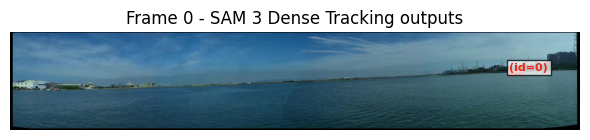

In [5]:
prompt_text_str = "boat"
frame_idx = 0
# Start a session
response = video_predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = video_predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

response = video_predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
output = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: output})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

propagate_in_video:   0%|          | 0/360 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

100% 360/360 [00:09<00:00, 38.80it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --e

Re-encoded video saved to ./assets/videos/S1_ch1234_20251029_1413_360frames.mp4_output.mp4


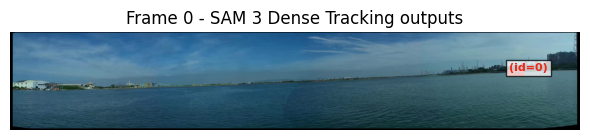

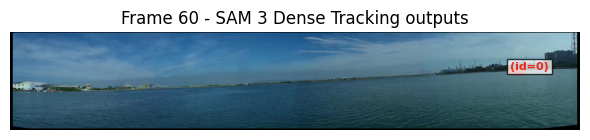

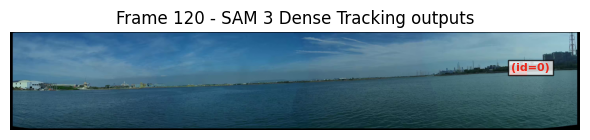

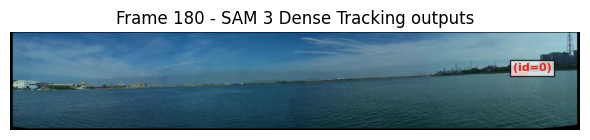

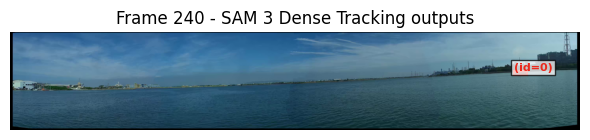

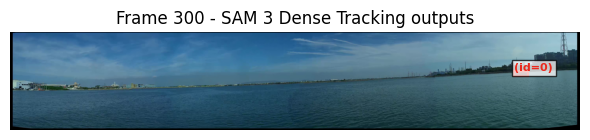

In [ ]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(video_predictor, session_id)
save_masklet_video(
    video_frames=video_frames_for_vis, 
    outputs=outputs_per_frame, 
    out_path=f"{video_path[:-4]}_output.mp4",
    fps=30, 
)
# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame_for_vis = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame_for_vis), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame_for_vis],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

In [ ]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = video_predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)
video_predictor.shutdown()

INFO 2026-02-11 09:58:28,498 115 sam3_video_predictor.py: 251: removed session 602e0436-3c92-43dd-a9ee-11da113839eb; live sessions: [], GPU memory: 8745 MiB used and 12888 MiB reserved (max over time: 12547 MiB used and 12888 MiB reserved)
